# RAIL Group Blender Visual Simulator

This notebook shows a few simple examples of using the visual simulator.

The most basic use of the simulator is to simply open Blender and request an image. Without providing a scene to open, Blender will use the default scene, which includes a single cube. Turning up the number of 'samples' is the number of ray cast operations per pixel in the scene. Increasing it will improve quality of the resulting render by decreasing noise, though for this simple scene it doesn't make much of a difference.


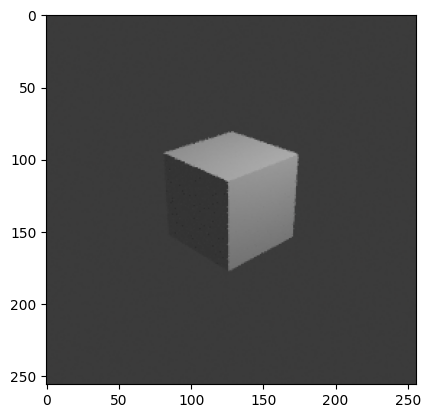

In [3]:
import matplotlib.pyplot as plt
from blendervsim import BlenderVSim

render_settings = {
    'samples': 4, 
    'resolution_x': 256, 
    'resolution_y': 256, 
    'use_denoising': False
}

with BlenderVSim() as blender:
    image = blender.render_image(render_settings=render_settings)

plt.imshow(image)
None

We can also optionally turn on "verbose" mode, which prints all outputs from within Blender.

In [4]:
with BlenderVSim(verbose=True) as blender:
    blender.echo("Hello from within Blender!")
    blender.echo(message="Hello (again) from within Blender!")
    image = blender.render_image(render_settings=render_settings)

[Blender Log] Printing data: Hello from within Blender!
[Blender Log] Printing data: Hello (again) from within Blender!
[Blender Log] Blender 4.2.4 LTS (hash e41b0e807a59 built 2024-11-19 00:31:24)
[Blender Log] Fra:1 Mem:10.96M (Peak 10.96M) | Time:00:00.02 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Synchronizing object | Cube
[Blender Log] Fra:1 Mem:10.96M (Peak 10.96M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Initializing
[Blender Log] Fra:1 Mem:10.78M (Peak 10.96M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Waiting for render to start
[Blender Log] Fra:1 Mem:10.78M (Peak 10.96M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Loading render kernels (may take a few minutes the first time)
[Blender Log] Fra:1 Mem:10.78M (Peak 10.96M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Updating Scene
[Blender Log] Fra:1 Mem:10.78M (Peak 10.96M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Updating Shaders
[B

## Plotting overhead maps with Blender

Next, let's try something a bit more complicated: plotting an overhead map. The `environments` package produces a `map_data` dictionary that our blender simulator can consume.

[Blender Log] Blender 4.2.4 LTS (hash e41b0e807a59 built 2024-11-19 00:31:24)
[Blender Log] Read blend: "/resources/blender_scenes/render_overhead.blend"
[Blender Log] Fra:100 Mem:14.58M (Peak 14.58M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Synchronizing object | hallway
[Blender Log] Fra:100 Mem:14.58M (Peak 14.58M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Synchronizing object | goal_path
[Blender Log] Fra:100 Mem:14.58M (Peak 14.58M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Synchronizing object | ground_tiled
[Blender Log] Fra:100 Mem:14.58M (Peak 14.58M) | Time:00:00.03 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Synchronizing object | background
[Blender Log] Fra:100 Mem:21.27M (Peak 21.95M) | Time:00:00.04 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Initializing
[Blender Log] Fra:100 Mem:20.85M (Peak 21.95M) | Time:00:00.05 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Waiting for render to start
[Blender Log] Fra:100 M

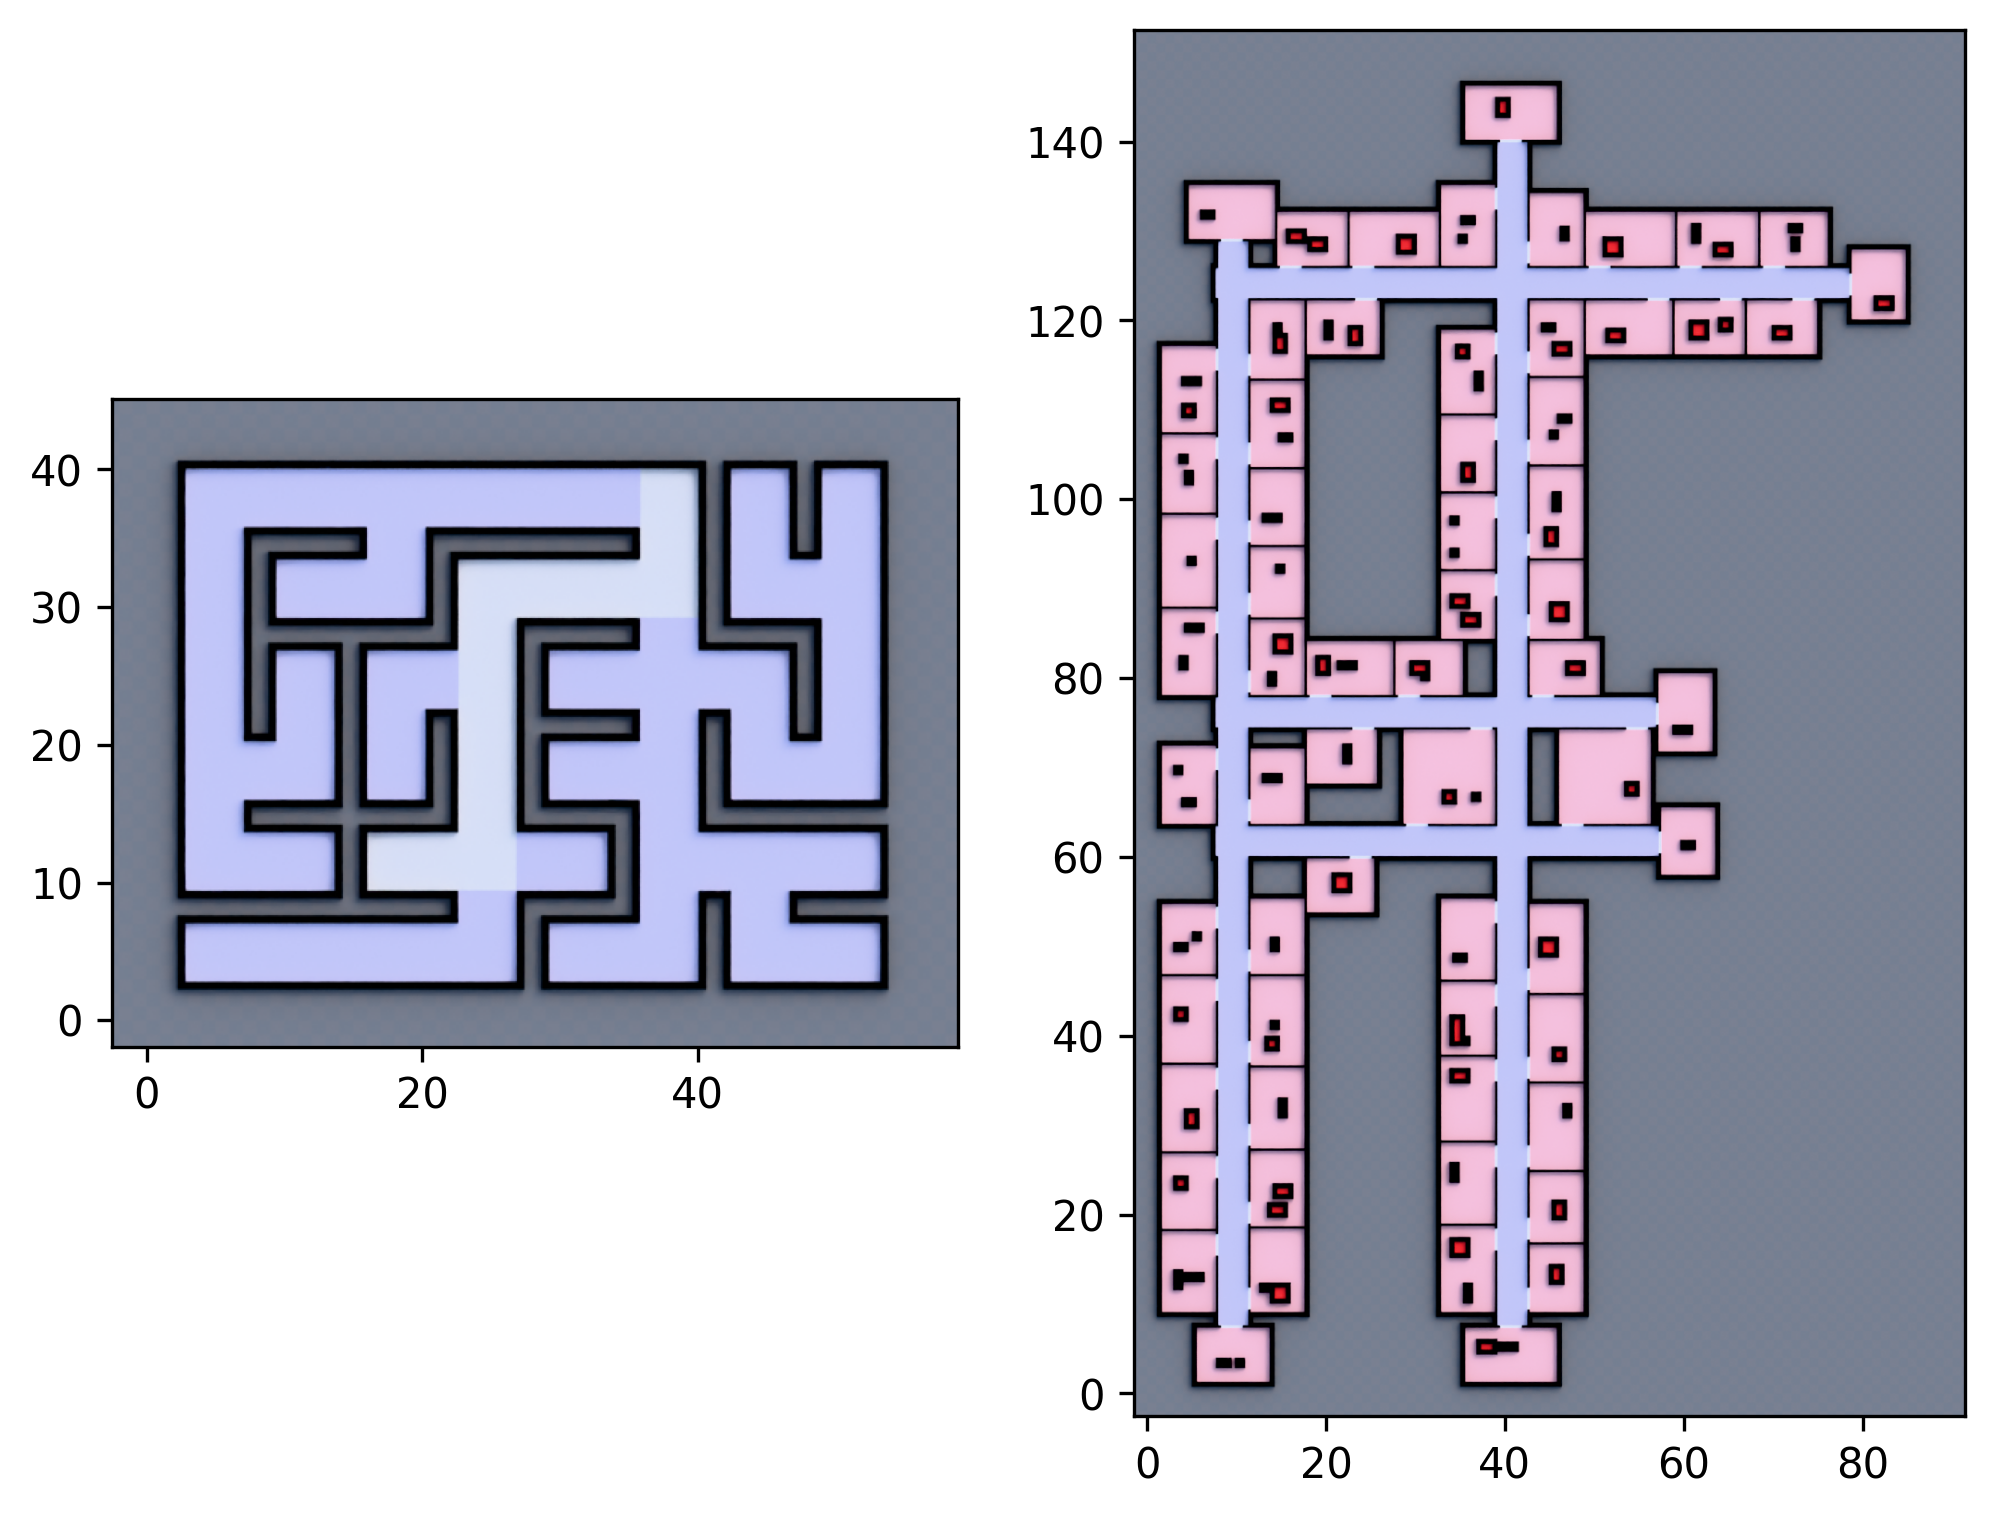

In [15]:
import numpy as np
import environments

def get_maze_map_data():
    # Set the arguments (usually done via the command line)
    args = lambda: None
    args.current_seed = 2005
    args.save_dir = './'

    # Robot Arguments
    args.step_size = 1.8
    args.num_primitives = 32
    args.laser_scanner_num_points = 1024
    args.field_of_view_deg = 360
    args.map_type = 'maze'

    known_map, map_data, pose, goal = environments.generate.map_and_poses(args)
    # FIXME: current version wants 'background' instead of 'walls'
    map_data['semantic_labels']['background'] = map_data['semantic_labels'].pop('wall')
    return map_data

def get_office_map_data():
    # Set the arguments (usually done via the command line)
    args = lambda: None
    args.current_seed = 2005
    args.save_dir = './'

    # Robot Arguments
    args.step_size = 1.8
    args.num_primitives = 32
    args.laser_scanner_num_points = 1024
    args.field_of_view_deg = 360
    args.map_type = 'office2'

    known_map, map_data, pose, goal = environments.generate.map_and_poses(args)
    map_data['resolution'] = 0.3
    return map_data

scene = "/resources/blender_scenes/render_overhead.blend"
with BlenderVSim(blender_scene_path=scene, verbose=True) as blender:
    maze_image, maze_im_data = blender.render_overhead(
        map_data=get_maze_map_data(),
        pixels_per_meter=10,
        edge_buffer_meters=2.5,
        render_settings={'samples': 16, 'use_denoising': True})
    
    office_image, office_im_data = blender.render_overhead(
        map_data=get_office_map_data(),
        pixels_per_meter=10,
        edge_buffer_meters=2.5,
        render_settings={'samples': 16, 'use_denoising': True})

plt.figure(figsize=(8, 6), dpi=300)
plt.subplot(121)
plt.imshow(maze_image, extent=maze_im_data['extent'])
plt.subplot(122)
plt.imshow(office_image, extent=office_im_data['extent'])
plt.show()